In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  

# Path to the CSV file containing the HTRU2 data
csv_file_path = '/home/afk/Documents/new/QRA/pulsar.csv'  

# Load the CSV file into a pandas DataFrame
dataset = pd.read_csv(csv_file_path)

# Print the first few rows of the dataframe to understand its structure
print(dataset.head())

# Assume the last column is the label and all other columns are features
X = dataset.iloc[:, :-1].values  # Feature columns
y = dataset.iloc[:, -1].values   # Label column

# Print label distribution to confirm that 0 represents non-pulsar and 1 represents pulsar
print("\nLabel distribution:")
print(f"0 (Non-pulsar): {np.sum(y == 0)} instances")
print(f"1 (Pulsar): {np.sum(y == 1)} instances")

# Normalize the features to the range [0, 1]
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Create a dataset list of dictionaries for shuffling
np_data_set = [{'features': features, 'label': label} for features, label in zip(X_normalized, y)]

# Shuffle the dataset
np.random.shuffle(np_data_set)

# Print the first 5 samples of the shuffled data
print("\nFirst 5 samples of encoded shuffled data:")
for sample in np_data_set[:5]:
    print(f"Features: {sample['features']}, Label: {sample['label']}")

# Extract shuffled features and labels
shuffled_features = np.array([sample['features'] for sample in np_data_set])
shuffled_labels = np.array([sample['label'] for sample in np_data_set])

# Perform a stratified split
train_features, test_features, train_labels, test_labels = train_test_split(
    shuffled_features,
    shuffled_labels,
    test_size=0.3,  # 30% of the data for testing
    stratify=shuffled_labels,  # Ensures proportional splits
    random_state=42  # For reproducibility
)

# Assign variables for train and test datasets
training_data = {'features': train_features, 'labels': train_labels}
test_data = {'features': test_features, 'labels': test_labels}

# Print the shapes of the training and test datasets
print(f"\nTraining features shape: {training_data['features'].shape}")
print(f"Training labels shape: {training_data['labels'].shape}")
print(f"Test features shape: {test_data['features'].shape}")
print(f"Test labels shape: {test_data['labels'].shape}")

# Count the number of instances of each label in the training and test datasets
train_label_counts = np.bincount(training_data['labels'])
test_label_counts = np.bincount(test_data['labels'])

print("\nLabel counts in the training dataset:")
print(f"0 (Non-pulsar): {train_label_counts[0]} instances")
print(f"1 (Pulsar): {train_label_counts[1]} instances")

print("\nLabel counts in the test dataset:")
print(f"0 (Non-pulsar): {test_label_counts[0]} instances")
print(f"1 (Pulsar): {test_label_counts[1]} instances")



   mean_int_pf     std_pf  ex_kurt_pf   skew_pf   mean_dm     std_dm  \
0   140.562500  55.683782   -0.234571 -0.699648  3.199833  19.110426   
1   102.507812  58.882430    0.465318 -0.515088  1.677258  14.860146   
2   103.015625  39.341649    0.323328  1.051164  3.121237  21.744669   
3   136.750000  57.178449   -0.068415 -0.636238  3.642977  20.959280   
4    88.726562  40.672225    0.600866  1.123492  1.178930  11.468720   

     kurt_dm     skew_dm  class  
0   7.975532   74.242225      0  
1  10.576487  127.393580      0  
2   7.735822   63.171909      0  
3   6.896499   53.593661      0  
4  14.269573  252.567306      0  

Label distribution:
0 (Non-pulsar): 16259 instances
1 (Pulsar): 1639 instances

First 5 samples of encoded shuffled data:
Features: [0.62268412 0.33330341 0.20565138 0.02306006 0.07036887 0.48060267
 0.17156582 0.00932551], Label: 1
Features: [0.43197691 0.23370028 0.27570613 0.05015932 0.00960955 0.11085599
 0.32007812 0.07317797], Label: 0
Features: [0.68863

In [13]:
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import BackendSampler
from functools import partial
#from qiskit import IBMQ
from qiskit.providers.basic_provider import BasicProvider


number_of_clients = 2   
epochs = 5  
max_train_iterations = 10
samples_per_epoch= 100
#backend = Aer.get_backend('aer_simulator')
backend = BasicProvider().get_backend("basic_simulator")


fl_avg_weight_range = [0.1, 1]


In [14]:
class Client:
    def __init__(self, dataset):
        self.models = []
        self.primary_model = None
        self.data = dataset
        self.test_scores = []
        self.train_scores = []

def distribute_data_to_clients(number_of_clients, epochs, samples_each_epoch, training_data):
    clients = []
    for i in range(number_of_clients):
        client_data = []
        for j in range(epochs):
            start_idx = (i * epochs * samples_per_epoch) + (j * samples_per_epoch)
            end_idx = (i * epochs * samples_per_epoch) + ((j + 1) * samples_per_epoch)
            images = training_data['features'][start_idx:end_idx]
            labels = training_data['labels'][start_idx:end_idx]
            epoch_data = [{'features': img, 'labels': lbl} for img, lbl in zip(images, labels)]
            client_data.append(epoch_data)
        clients.append(Client(client_data))
    return clients

# Example usage:
clients = distribute_data_to_clients(number_of_clients, epochs, samples_per_epoch, training_data)
# Check the label distribution for the first epoch of the first client
for idx, client in enumerate(clients):
    labels = [data_point['labels'] for data_point in client.data[0]]  # Access the 'labels' key for the first epoch of the first client
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(f"Client {idx}, Epoch 0 - Labels: {dict(zip(unique_labels, counts))}")


Client 0, Epoch 0 - Labels: {0: 90, 1: 10}
Client 1, Epoch 0 - Labels: {0: 93, 1: 7}


In [15]:
iteration = 0

def training_callback(weights, obj_func_eval):
    global iteration
    iteration += 1
    print(f"{iteration}", end=' | ')

# Define the training function
def train_model(dataset, model=None):
    if isinstance(dataset, list) and len(dataset) > 0 and 'features' in dataset[0] and 'labels' in dataset[0]:
        train_features = [data_point["features"] for data_point in dataset]
        train_labels = [data_point["labels"] for data_point in dataset]
    else:
        raise ValueError("Data must be a list of dictionaries with 'features' and 'labels' keys.")
    
    # Convert the lists to NumPy arrays
    train_features = np.array(train_features)
    train_labels = np.array(train_labels)

    # Print the shapes
    print("Train features Shape:", train_features.shape)
    print("Train Labels Shape:", train_labels.shape)

    # Create a new model if one is not provided
    if model is None:
        num_features = len(train_features[0])
        feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
        ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
        optimizer = COBYLA(maxiter=max_train_iterations) 
        model = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            callback=partial(training_callback),
            sampler=BackendSampler(backend=backend),
            warm_start=True
        )

    # Training
    print("Starting Training")
    start_time = time.time()
    model.fit(train_features, train_labels)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nTraining complete. Elapsed time: {elapsed_time} seconds.")

    # Scoring
    print("Evaluating Model Performance")
    train_score = model.score(train_features, train_labels)
    test_score = model.score(test_features, test_labels)

    return train_score, test_score, model

In [16]:
# Define the function to get accuracy of the model with specific weights
def calculate_accuracy(weights, test_num=200):
    test_num = min(test_num, len(test_features)) 
    num_features = len(test_features[0])
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
    optimizer = COBYLA(maxiter=0)  
    vqc_model = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        sampler=BackendSampler(backend=backend),
        initial_point=weights  
    )
    # Train the model on a small subset of the test data (for quick evaluation)
    vqc_model.fit(test_features[:25], test_labels[:25])
    accuracy = vqc_model.score(test_features[:test_num], test_labels[:test_num])
    return accuracy

# Define the function to create a VQC model with specific weights
def initialize_model_with_weights(weights):
    num_features = len(test_features[0])
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
    optimizer = COBYLA(maxiter=max_train_iterations)  
    vqc_model = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        sampler=BackendSampler(backend=backend),
        warm_start=True,
        initial_point=weights, 
        callback=partial(training_callback)
    )
    return vqc_model

In [17]:
import warnings

# Temporary code to suppress all FutureWarnings for a cleaner output
warnings.simplefilter("ignore", FutureWarning)


In [18]:
import numpy as np


def average_weights_simple(epoch_results, last_epoch_weights=None, last_epoch_accuracy=None):
    if last_epoch_weights is not None:
        epoch_results['weights'].append(last_epoch_weights)
        epoch_results['test_scores'].append(last_epoch_accuracy)

    weights_list = epoch_results['weights']
    num_features = len(weights_list[0])
    averages = np.mean(weights_list, axis=0)
    
    return averages.tolist()


In [19]:

averaging_techniques = {
    'Simple_Averaging': average_weights_simple
}
clients_array_2d = [[] for _ in range(len(averaging_techniques))]

for index, (technique_name, _) in enumerate(averaging_techniques.items()):
        for client in clients:
          client_copy = Client(client.data)
          clients_array_2d[index].append(client_copy)


clients_array_2d

[[<__main__.Client at 0x7f7f41905a60>, <__main__.Client at 0x7f7f41904d70>]]

In [20]:
global_model_weights = []
global_model_accuracy = []

for outer_idx, clients in enumerate(clients_array_2d):
    technique_name = list(averaging_techniques.keys())[outer_idx]
    technique_function = list(averaging_techniques.values())[outer_idx]
    print(f"Technique Name: {technique_name}")
    global_model_weights.append([])
    global_model_accuracy.append([])

    for epoch in range(epochs):
        epoch_results = {
            'weights': [],
            'test_scores': []
        }
        print(f"Epoch: {epoch}")

        for index, client in enumerate(clients):
            print(f"Index: {index}, Client: {client}")

            client_data = client.data[epoch]

            if client.primary_model is None:
                train_score_q, test_score_q, model = train_model(dataset=client_data)
                client.models.append(model)
                client.test_scores.append(test_score_q)
                client.train_scores.append(train_score_q)
                # Print the values
                print("Train Score:", train_score_q)
                print("Test Score:", test_score_q)
                print("\n\n")
                epoch_results['weights'].append(model.weights)
                epoch_results['test_scores'].append(test_score_q)

            else:
                train_score_q, test_score_q, model = train_model(dataset=client_data, model=client.primary_model)
                client.models.append(model)
                client.test_scores.append(test_score_q)
                client.train_scores.append(train_score_q)
                print("Train Score:", train_score_q)
                print("Test Score:", test_score_q)
                print("\n\n")
                epoch_results['weights'].append(model.weights)
                epoch_results['test_scores'].append(test_score_q)

        new_global_weights = []
        if epoch == 0:
            new_global_weights = technique_function(epoch_results)
        else:
            new_global_weights = technique_function(epoch_results, global_model_weights[outer_idx][epoch - 1], global_model_accuracy[outer_idx][epoch - 1])
        print(new_global_weights)
        global_model_weights[outer_idx].append(new_global_weights)
        new_model_with_global_weights = initialize_model_with_weights(global_model_weights[outer_idx][epoch])

        for index, client in enumerate(clients):
            client.primary_model = new_model_with_global_weights

        global_accuracy = calculate_accuracy(global_model_weights[outer_idx][epoch], len(test_data['features']))
        global_model_accuracy[outer_idx].append(global_accuracy)
        print(f"Technique Name: {technique_name}")
        print(f"Global Model Accuracy In Epoch {epoch}: {global_accuracy}")
        print("----------------------------------------------------------")


Technique Name: Simple_Averaging
Epoch: 0
Index: 0, Client: <__main__.Client object at 0x7f7f41905a60>
Train features Shape: (100, 8)
Train Labels Shape: (100,)
Starting Training
1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 
Training complete. Elapsed time: 17.830562114715576 seconds.
Evaluating Model Performance
Train Score: 0.88
Test Score: 0.8271880819366852



Index: 1, Client: <__main__.Client object at 0x7f7f41904d70>
Train features Shape: (100, 8)
Train Labels Shape: (100,)
Starting Training
11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 
Training complete. Elapsed time: 34.07182192802429 seconds.
Evaluating Model Performance
Train Score: 0.58
Test Score: 0.6329608938547486



[1.6338528839268975, 0.45242638895290965, 0.23851300129645459, 0.6839119809388705, 0.12366584830964661, 0.48051032575432717, 0.6266760264654474, 0.593784039230913, 1.4056611643683805, 0.4472554049204407, 0.4921140014341097, 0.4502452005081058, 0.14755674702535093, 0.49409574553570784, 0.14139749963690623, 0

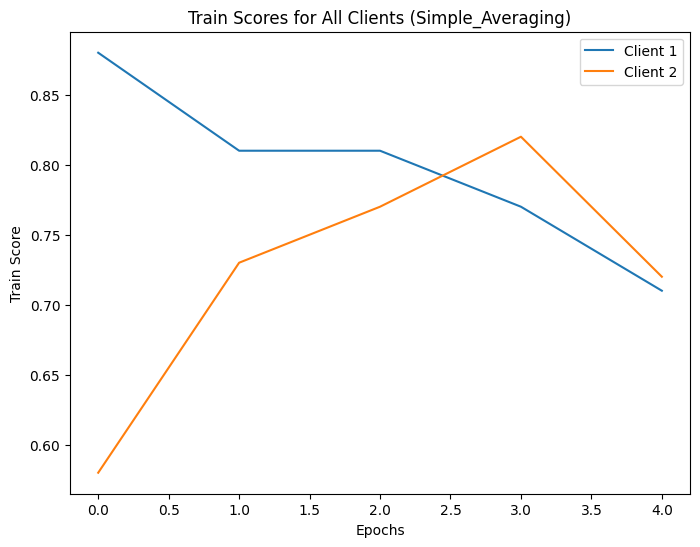

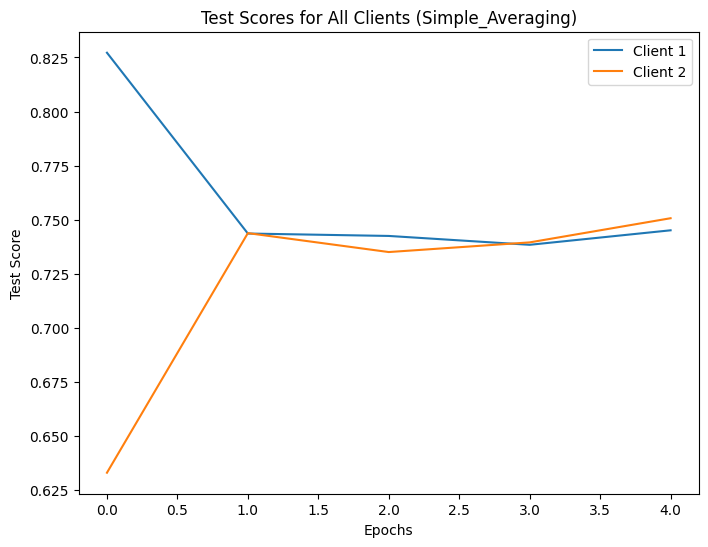

In [23]:
import matplotlib.pyplot as plt

# Create plots for train scores and test scores for each technique
for technique_idx, clients_list in enumerate(clients_array_2d):
    technique_name = list(averaging_techniques.keys())[technique_idx]

    # Plot train scores for all clients
    plt.figure(figsize=(8, 6))
    for client_idx, client in enumerate(clients_list):
        plt.plot(client.train_scores, label=f'Client {client_idx + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Train Score')
    plt.title(f"Train Scores for All Clients ({technique_name})")
    plt.legend()
    plt.show()

    # Plot test scores for all clients
    plt.figure(figsize=(8, 6))
    for client_idx, client in enumerate(clients_list):
        plt.plot(client.test_scores, label=f'Client {client_idx + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Test Score')
    plt.title(f"Test Scores for All Clients ({technique_name})")
    plt.legend()
    plt.show()


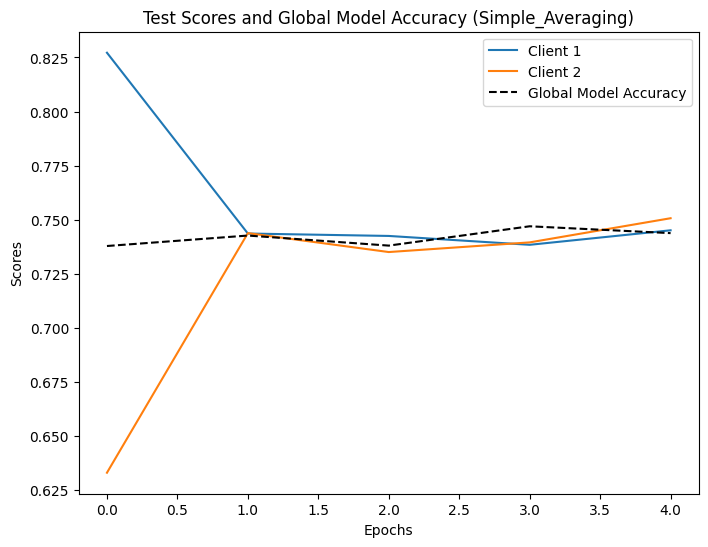

In [22]:
import matplotlib.pyplot as plt

# Create plots for test scores and global model accuracy for each technique
for technique_idx, clients_list in enumerate(clients_array_2d):
    technique_name = list(averaging_techniques.keys())[technique_idx]

    # Create a new figure for test scores and global model accuracy
    plt.figure(figsize=(8, 6))

    # Plot test scores for all clients
    for client_idx, client in enumerate(clients_list):
        plt.plot(client.test_scores, label=f'Client {client_idx + 1}')

    # Plot global model accuracy
    plt.plot(global_model_accuracy[technique_idx], label='Global Model Accuracy', linestyle='--', color='black')

    plt.xlabel('Epochs')
    plt.ylabel('Scores')
    plt.title(f"Test Scores and Global Model Accuracy ({technique_name})")
    plt.legend()

    # Show the combined graph
    plt.show()
